## Brain Tumor Detection

In [1]:
# Import necessary modules
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2

In [8]:
# Cargamos las imagenes desde nuestro directorio:
path = "C:/Users/jesus/Desktop/tfm_jesus/brain_tumor_dataset"
print(os.listdir(path))

image_paths = list(paths.list_images(path))
print(len(image_paths))

['no', 'yes']
253


In [3]:
# En este bloque vamos a recorrer todas las fotos gracias al path anteriormente definido. Con la función cv2, vamos a convertir las imagenes en información de pixeles y definimos el tamaño en 224 pixeles.
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    images.append(image)
    labels.append(label)

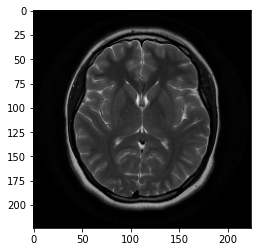

In [4]:
# Hacemos plot de una imagen para ver como ha quedado: 
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])

In [ ]:
#Como se puedes ver, hemos guardado las imagenes y sus respectivas etiquetas en listas. Pero las etiquetas son strings y la máquina no podrá interpretarlas. 
#Por lo tanto, aplicamos la codificación One-hot a las etiquetas.

In [5]:
#Ahora para seguir trabajando vamos a convertir las fotos en array:
images = np.array(images) / 255.0
labels = np.array(labels)

In [6]:
# Ejecutando el One-hot encoding
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

print(labels[0])

[1. 0.]


In [7]:
#Dividimos el dataset
(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)

In [8]:
# Rellenamos de pixeles las fotos a los pixeles más cercanos.
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

In [9]:
# Creamos el modelo:
base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input
base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

58900480/58889256 [==============================] - 6s 0us/step


In [10]:
for layer in base_model.layers:
    layer.trainable = False

In [11]:
# Compilamos el modelo
model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [12]:
#Este comando nos permite ver la estructura del modelo:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
batch_size = 8
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 10

In [14]:
# Fit del modelo
history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size),
                              steps_per_epoch= train_steps,
                              validation_data = (test_X, test_Y),
                              validation_steps= validation_steps,
                              epochs= epochs)

<ipython-input-14-261dfbd5bc3e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size),


Epoch 1/10
28/28 [==============================] - 24s 834ms/step - loss: 0.7175 - accuracy: 0.5662 - val_loss: 0.6160 - val_accuracy: 0.6538
Epoch 2/10
28/28 [==============================] - 24s 873ms/step - loss: 0.6502 - accuracy: 0.6256 - val_loss: 0.5687 - val_accuracy: 0.7692
Epoch 3/10
28/28 [==============================] - 25s 887ms/step - loss: 0.6251 - accuracy: 0.6575 - val_loss: 0.5503 - val_accuracy: 0.9231
Epoch 4/10
28/28 [==============================] - 25s 890ms/step - loss: 0.5892 - accuracy: 0.7580 - val_loss: 0.5075 - val_accuracy: 0.9231
Epoch 5/10
28/28 [==============================] - 25s 884ms/step - loss: 0.5732 - accuracy: 0.7443 - val_loss: 0.4629 - val_accuracy: 0.9615
Epoch 6/10
28/28 [==============================] - 25s 884ms/step - loss: 0.5531 - accuracy: 0.7397 - val_loss: 0.4307 - val_accuracy: 0.9615
Epoch 7/10
28/28 [==============================] - 24s 874ms/step - loss: 0.5433 - accuracy: 0.7352 - val_loss: 0.3763 - val_accuracy: 0.9231

In [15]:
# Evaluamos el modelo
predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

In [16]:
# Print del Classification report y la matriz de confusión
print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)

              precision    recall  f1-score   support

          no       0.77      1.00      0.87        10
         yes       1.00      0.81      0.90        16

    accuracy                           0.88        26
   macro avg       0.88      0.91      0.88        26
weighted avg       0.91      0.88      0.89        26

[[10  0]
 [ 3 13]]


In [17]:
#Accuracy final de nuestro modelo
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.8846


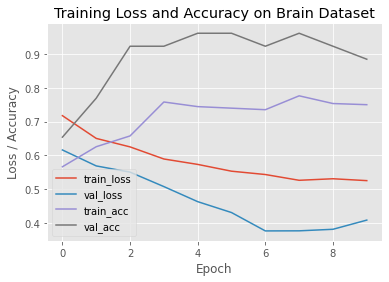

In [18]:
# Hacemos plot de Loss y del accuracy: 
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")